-- Take satellite tracks from satellite analysis and interpolate model fields to these points at each 5 day snapshot. Export the resulting SSH and treat at satellite in filtering library

Goal: Compare resulting KE estimate to actual model KE 

Problem: Current model resolution is 1/4 degree so if going to estimate KE from SSH gradients will be extremely coarse 
-- for now interpolate sqrt(KE) onto satellite tracks representing a speed like that calculated from along-track gradients 

The code below is run to interpolate and extract model surface fields to then process as we do with altimeter measurements 

In [12]:
import pickle 
import numpy as np
from scipy.interpolate import griddata 
import cmocean
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import xarray as xr

In [5]:
# load dataset
x1 = xr.open_dataset('/Users/jakesteinberg/Desktop/neverworld/snapshots_00032505.nc', decode_times=False)
# -- load in a few variables 
lat = x1.yh.values
lon = x1.xh.values
time = x1.time.values

In [15]:
# satellite tracks on model 
this_sat = 'j2'
filter_type = 'sharp'
load_sat = pickle.load(open('/Users/jakesteinberg/Documents/CPT/altimetry/' + \
                            this_sat + '_' + filter_type + '_processed.p', 'rb'))
lon_sat = load_sat['lon_record']
lat_sat = load_sat['lat_record']
track_sat = load_sat['track']

lon_w = 10
lon_e = 45
lat_s = -60
lat_n = -25
Lon, Lat = np.meshgrid(lon, lat)
Lon_f = Lon.flatten()
Lat_f = Lat.flatten()
points = np.concatenate((Lon_f[:, None], Lat_f[:, None]), axis=1)

In [ ]:
# --- plot and interpolate ssh (or say KE) to satellite lat/lon positions
# - say that satellite grid pattern is completed every time step...or every 5 days 
# - model fields are snapshots
lon_sim = []
lat_sim = []
dist_sim = []
e_sim = []
track = []
time_steps_i = 1  # !!!!!!!!!!!!! np.shape(e)[0]  # each step is 5 days 
this_var = x1.KE.values[:, 0, :, :]

f, ax = plt.subplots(1, 1, figsize=(7,9))
levs = np.linspace(7*10**(-8), 7*10**(-1), 100)
ax.pcolormesh(x1.xh, x1.yh, x1.KE.values[-1, 0], cmap = cmocean.cm.matter_r, \
              zorder=0, vmin=levs[0], vmax=levs[-1])
count = 0
for i in tqdm(range(len(lon_sat))):  
    # satellite lon,lat coordinates (consider places on coarser grid...now on 10 km grid)
    this_lon = (lon_sat[i] - 360) + 60
    this_lat = -1.0 * lat_sat[i]
    lon_lat_in = np.where((this_lon > lon_w) & (this_lon < lon_e) & (this_lat > lat_s) & (this_lat < lat_n))[0]
    if (len(lon_lat_in) > 20):
        ax.scatter(this_lon[lon_lat_in], this_lat[lon_lat_in], s=1, color='w', zorder=2)
        # lat/lon
        lon_sim.append(this_lon[lon_lat_in])
        lat_sim.append(lat_sat[i][lon_lat_in])
        
        dx = np.nan * np.ones(len(lat_sim[count]) - 1)
        dy = np.nan * np.ones(len(lat_sim[count]) - 1)
        for k in range(1, len(lat_sim[count])):
            dx[k - 1] = 1852 * 60 * np.cos(np.deg2rad(lat_sim[count][k])) * (lon_sim[count][k] - lon_sim[count][k - 1])
            dy[k - 1] = 1852 * 60 * (lat_sim[count][k] - lat_sim[count][k - 1]) 
        dist = np.concatenate((np.array([0]), np.sqrt(np.cumsum(dx)**2 + np.cumsum(dy)**2)))
        dist_sim.append(dist)
        
        # variable we want to interpolate 
        this_e = np.nan * np.ones((np.shape(this_var)[0], len(this_lon[lon_lat_in])))
        for j in range(time_steps_i):  # loop over each time step 
            # values = np.squeeze(e[j, 0, :, :]).flatten()
            values = np.squeeze(this_var[j, :, :]).flatten()
            this_e[j, :] = griddata(points, values, \
                                    np.concatenate((this_lon[lon_lat_in][:, None], this_lat[lon_lat_in][:, None]), \
                                                   axis=1))
        track.append(track_sat[i])
        e_sim.append(this_e)
        count = count + 1
        
ax.set_xlim([0, 60])
ax.set_ylim([-60, 60])
plt.show()

/Users/jakesteinberg/anaconda3/envs/cpt/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater
/Users/jakesteinberg/anaconda3/envs/cpt/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in less


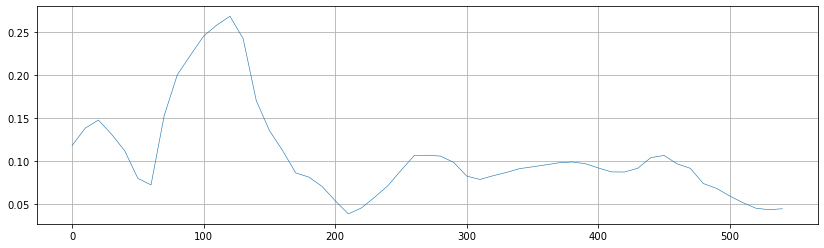

In [17]:
test_i = 10
f, ax = plt.subplots(1, 1, figsize=(14, 4))
for i in range(np.shape(e_sim[test_i])[0]):
    ax.plot(dist_sim[test_i]/1000,np.sqrt(e_sim[test_i][i, :]), linewidth=0.6)
ax.grid()
plt.show()

In [ ]:
save_sim = 0
if save_sim:
    outputs = {'dist': dist, \
               'ke': e_sim, \
                'time': time, \
                'lon': lon_sim, \
                'lat': lat_sim, \
                'track': track}
    pickle.dump(outputs, open('/Users/jakesteinberg/Desktop/neverworld/j2_simulated_ke.p', 'wb'))